# Producing the Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

## Notebook Initialization

In [2]:
%autoreload
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
import darkhistory.physics as phys
import darkhistory.utilities as utils

from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

# np.set_printoptions(threshold=np.nan)

## Import Raw Data

In [3]:
# For complete_coarse
# xes_str = [
#     '4.540E-05', '2.746E-04'
# ]

xes_str = [
    '4.540E-05', '2.746E-04', '1.659E-03', '9.952E-03', '5.732E-02',
    '2.689E-01', '6.900E-01', '9.309E-01', '9.879E-01', '9.980E-01',
    '9.997E-01'   
]

# file_names = [
#     '/Users/hongwan/Dropbox (MIT)/Photon Deposition/'
#     +'transferfunction_injE_complete_z_30_xe_2_pts/'
#     +'transferfunction_withloweng_cmbloss_60eV_fixed_binning_injE_complete_z_30_xe_'
#     +str+'_nointerp.p'
#     for str in xes_str    
# ]

file_names = [
    '/Users/hongwan/Dropbox (MIT)/Photon Deposition/'
    +'transferfunction_complete/'
    +'transferfunction_withloweng_cmbloss_60eV_fixed_binning_complete_xe_'
    +str+'_nointerp.p'
    for str in xes_str    
]

raw_tf_tuple = [pickle.load(open(file_name, "rb")) for file_name in file_names]

# xe, in_eng, rs, eng, type={highengphot, lowengphot, lowengelec}
raw_tf_list = np.array([tup[0] for tup in raw_tf_tuple])
# Truncate the energy binning, because in_eng does not go up to the end.
# raw_tf_list = raw_tf_list[:,:,:,:494,:]
# xe, in_eng, rs
CMB_engloss_list = np.array([tup[1] for tup in raw_tf_tuple])
# xe, in_eng, rs, {H-ion, Exc, Heating, Cont.}
highdeposited_list = np.array([tup[2] for tup in raw_tf_tuple])
# xe, in_eng, rs, type={mwimp, rs}
info_list = np.array([tup[3] for tup in raw_tf_tuple])
# xe, in_eng, rs, type={photeng, eleceng}, eng
abscissae_list = np.array([tup[4] for tup in raw_tf_tuple])
# abscissae_list = abscissae_list[:,:,:,:,:494]



In [5]:
# This checks that all of the abscissae are equal.
for i in np.arange(info_list.shape[0]):
    for j in np.arange(info_list.shape[1]):
        if not np.array_equal(
            info_list[i,j,:,1],
            info_list[0,0,:,1]
        ):
            print('NOPE!')
        for k in np.arange(info_list.shape[2]):
            if not np.array_equal(
                info_list[i,:,k,0],
                info_list[0,:,0,0]
            ):
                print('NOPE!')
            if not np.array_equal(
                abscissae_list[i,j,k,0,:],
                abscissae_list[0,0,0,0,:]
            ):
                print('NOPE!')
            if not np.array_equal(
                abscissae_list[i,j,k,1,:],
                abscissae_list[0,0,0,1,:]
            ):
                print('NOPE!')
                
# Given that they are, let's just define photeng and eleceng. 
# xe_arr = 0.5 + 0.5*np.tanh(
#     np.array(
#         [-5., -4.1]
#     )
# )

xe_arr = 0.5 + 0.5*np.tanh(
    [-5., -4.1, -3.2, -2.3, -1.4, 
        -0.5, 0.4, 1.3, 2.2, 3.1, 4.]
)

rs_arr    = info_list[0,0,:,1]
mwimp_arr = info_list[0,:,0,0]
photeng = abscissae_list[0,0,0,0,:]
eleceng = abscissae_list[0,0,0,1,:]

(1+z) at this index:  33.27205392042539
in_eng at this index:  259.14427472490325
0.0
0.0


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


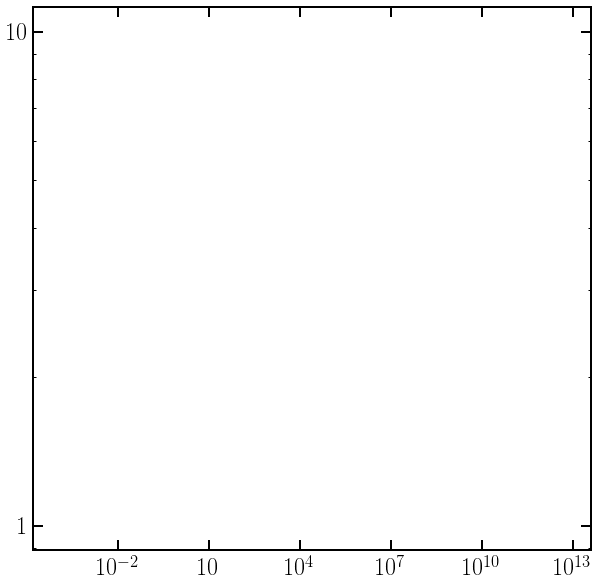

In [6]:
#### SANDBOX, DELETE WHEN DONE ####

i_rs = 16
i_in_eng = 18

#xe, in_eng, rs
CMBloss = CMB_engloss_list[0, i_in_eng, i_rs]

# xe, in_eng, rs, eng, type={highengphot, lowengphot, lowengelec}
spec = raw_tf_list[0,i_in_eng, i_rs, :, 0]


dt = 0.001/phys.hubble(rs_arr[i_rs])
# print(phys.hubble(rs_arr[i_rs]))
dlne = np.log(photeng[1]) - np.log(photeng[0])

print('(1+z) at this index: ', rs_arr[i_rs])
print('in_eng at this index: ', mwimp_arr[i_in_eng])
print(CMBloss*dt)
print(np.dot(spec, photeng**2)*dlne)

plt.figure()

ax = plt.gca()
ax.loglog()

plt.plot(photeng, spec)

## Raw Data Manipulation

The transfer function is calculated by injecting 2 photons at the input energy abscissa. However, the first step is to assign $x$ photons to the top bin of the *output* photon abscissa, such that $x$ times the energy of the top bin is 2 times the injection energy. Because of the misalignment between the two abscissae, as well as the fact that we want to transfer function for a single electron, we have to normalize the results first.

First, we construct two arrays: a list of output abscissae (for both photons and electrons) given the injection abscissa, and a list of the energy of the *output* photon energy bin where the injected photons are assigned to. Then we compute the normalization factor. 

In [7]:
# This treatment is consistent with ih_transferfunction
photeng_bin_width = np.diff(np.log(spectools.get_bin_bound(photeng))) * photeng
eleceng_bin_width = np.diff(np.log(spectools.get_bin_bound(eleceng))) * eleceng


# Original injection energies
top_photeng_bins = np.array(
    [
        photeng[photeng <= mwimp][-1]
        for mwimp in mwimp_arr
    ]
)

norm_fac_arr = 2*mwimp_arr/top_photeng_bins

In [8]:
utils.compare_arr([mwimp_arr, top_photeng_bins, norm_fac_arr])
utils.compare_arr([photeng, eleceng])

[[6.46699012e+01 6.46699012e+01 2.00000000e+00]
 [6.98543211e+01 6.98543211e+01 2.00000000e+00]
 [7.54543627e+01 7.54543627e+01 2.00000000e+00]
 [8.15033452e+01 8.15033452e+01 2.00000000e+00]
 [8.80372591e+01 8.80372591e+01 2.00000000e+00]
 [9.50949801e+01 9.50949801e+01 2.00000000e+00]
 [1.02718501e+02 1.02718501e+02 2.00000000e+00]
 [1.10953179e+02 1.10953179e+02 2.00000000e+00]
 [1.19848010e+02 1.19848010e+02 2.00000000e+00]
 [1.29455918e+02 1.29455918e+02 2.00000000e+00]
 [1.39834066e+02 1.39834066e+02 2.00000000e+00]
 [1.51044204e+02 1.51044204e+02 2.00000000e+00]
 [1.63153030e+02 1.63153030e+02 2.00000000e+00]
 [1.76232590e+02 1.76232590e+02 2.00000000e+00]
 [1.90360704e+02 1.90360704e+02 2.00000000e+00]
 [2.05621433e+02 2.05621433e+02 2.00000000e+00]
 [2.22105575e+02 2.22105575e+02 2.00000000e+00]
 [2.39911209e+02 2.39911209e+02 2.00000000e+00]
 [2.59144275e+02 2.59144275e+02 2.00000000e+00]
 [2.79919206e+02 2.79919206e+02 2.00000000e+00]
 [3.02359610e+02 3.02359610e+02 2.000000

0

Dividing by the normalization factor gives the spectra for the injection of 1 photon, with energy given by `top_photeng_bins`. 

Now we construct a raw array of all of the transfer functions, on which we will perform an interpolation to extract a set of transfer functions for use, given a chosen abscissa.

In [9]:
# Multiplying by bin width converts all the eleceng array into number of particles. 
# Indexing: xe, in_eng, rs, eng, type={highengphot, lowengphot, lowengelec}

phot_tf_raw = np.array([
    [
        [
            raw_tf[i,j,:,0]/norm_fac*photeng_bin_width
                for (j, rs) in enumerate(rs_arr)   
        ]
        for (i, (in_eng, norm_fac)) in enumerate(zip(mwimp_arr, norm_fac_arr))
        
    ] for raw_tf in tqdm(raw_tf_list)
])

lowengphot_tf_raw = np.array([
    [
        [
            raw_tf[i,j,:,1]/norm_fac*photeng_bin_width 
                for (j, rs) in enumerate(rs_arr)   
        ]
        for (i, (in_eng, norm_fac)) in enumerate(zip(mwimp_arr, norm_fac_arr))
        
    ] for raw_tf in tqdm(raw_tf_list)
])

lowengelec_tf_raw = np.array([
    [
        [
            raw_tf[i,j,:,2]/norm_fac*eleceng_bin_width 
                for (j, rs) in enumerate(rs_arr)   
        ]
        for (i, (in_eng, norm_fac)) in enumerate(zip(mwimp_arr, norm_fac_arr))
        
    ] for raw_tf in tqdm(raw_tf_list)
])

# xe, in_eng, rs
CMB_engloss = CMB_engloss_list/np.outer(norm_fac_arr, np.ones_like(rs_arr))

# xe, in_eng, rs, {H-Ion, Exc, Heat, Cont}
denom_highdeposited = np.ones((xe_arr.size, rs_arr.size, 4, norm_fac_arr.size))
denom_highdeposited *= norm_fac_arr
denom_highdeposited = np.rollaxis(denom_highdeposited, 3, 1)
highdeposited = highdeposited_list/denom_highdeposited

## Some Plots to Check

In [10]:
phot_tf_raw.shape

(11, 327, 51, 500)

68989219.05840614
69039304.53498155


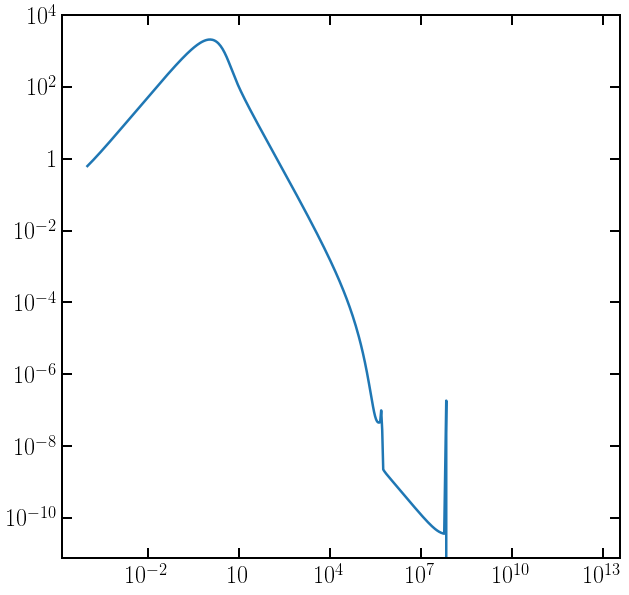

In [11]:
plt.figure()

injE_ind = 180

#xe, in_eng, rs, eng
plt.plot(photeng, phot_tf_raw[-1, injE_ind , -1, :]/photeng_bin_width)

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

# These two should be similar: 
# It is the file total energy in the high energy photon spectrum
# compared to the injection energy. 
print(np.dot(photeng, phot_tf_raw[-1, injE_ind, -1, :]))
print(top_photeng_bins[injE_ind])

In [12]:
photeng_high = photeng[photeng > 60]
print(photeng_high.shape)

new_phot_tf_raw = phot_tf_raw
new_lowengphot_tf_raw = lowengphot_tf_raw
new_lowengelec_tf_raw = lowengelec_tf_raw
new_cmbloss_raw = CMB_engloss
new_highdeposited_raw = highdeposited

(327,)


Now, we construct the list of `Spectrum` objects from our raw array of transfer functions...

In [13]:
# spec_type = 'N' for eleceng, because we have already multiplied in the bin width earlier. 

#xe, in_eng, rs, eng
photspec_list = [
    [
        [
            Spectrum(
                photeng, phot_tf[i,j,:], spec_type='N', 
                rs = rs, in_eng = in_eng
            ) for (j, rs) in enumerate(rs_arr)
        ] for (i, in_eng) in enumerate(photeng_high)
    ] for phot_tf in tqdm(new_phot_tf_raw)
]

lowengphotspec_list = [
    [
        [
            Spectrum(
                photeng, lowengphot_tf[i,j,:], spec_type='N', 
                rs = rs, in_eng = in_eng
            ) for (j, rs) in enumerate(rs_arr)
        ] for (i, in_eng) in enumerate(photeng_high)
    ] for lowengphot_tf in tqdm(new_lowengphot_tf_raw)
]

lowengelecspec_list = [
    [
        [
            Spectrum(
                eleceng, lowengelec_tf[i,j,:], spec_type='N', 
                rs = rs, in_eng = in_eng
            ) for (j, rs) in enumerate(rs_arr)
        ] for (i, in_eng) in enumerate(photeng_high)
    ] for lowengelec_tf in tqdm(new_lowengelec_tf_raw)
]


Finally, we can construct the `TransferFuncList` from this.

In [14]:
tfunclist_photspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.001)
            for spec_arr in photspec_xe
        ]
    ) for photspec_xe in tqdm(photspec_list)
]

tfunclist_lowengphotspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.001)
            for spec_arr in lowengphotspec_xe
        ]
    ) for lowengphotspec_xe in tqdm(lowengphotspec_list)
]
    

tfunclist_lowengelecspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.001)
            for spec_arr in lowengelecspec_xe
        ]
    ) for lowengelecspec_xe in tqdm(lowengelecspec_list)
]

We will now transpose all of the `TransferFuncList` objects so that they are now all of type `'rs'`.

In [15]:
for tflist_hep, tflist_lep, tflist_lee in zip(
    tfunclist_photspec_list, tfunclist_lowengphotspec_list, tfunclist_lowengelecspec_list):
    tflist_hep.transpose()
    tflist_lep.transpose()
    tflist_lee.transpose()
    for i, tf_hep, tf_lep, tf_lee in zip(np.arange(327), tflist_hep, tflist_lep, tflist_lee):
        if np.any(np.isnan(tf_hep._grid_vals)):
            print(np.where(np.isnan(tf_hep._grid_vals)),'here!')
        if np.any(np.isnan(tf_lep._grid_vals)):
            print(np.where(np.isnan(tf_lep._grid_vals)),'here1!')
        if np.any(np.isnan(tf_lee._grid_vals)):
            print(np.where(np.isnan(tf_lee._grid_vals)),'here2!')
        
        tf_hep._grid_vals[np.where(tf_hep.grid_vals < 0)] = 1e-100
        tf_lep._grid_vals[np.where(tf_lep.grid_vals < 0)] = 1e-100
        tf_lee._grid_vals[np.where(tf_lee.grid_vals < 0)] = 1e-100

In [16]:
tfunclist_photspec_list[0].rs

array([   4.        ,    4.56626611,    5.21269655,    5.9506399 ,
          6.79305133,    7.75472002,    8.85252881,   10.10575058,
         11.5363866 ,   13.16955279,   15.03392065,   17.1622206 ,
         19.59181658,   22.36536203,   25.53154867,   29.14596137,
         33.27205392,   37.98226307,   43.35928017,   49.49750292,
         56.50469254,   64.50386567,   73.63545397,   84.05976951,
         95.95981921,  109.54451763,  125.05235464,  142.75558229,
        162.9649944 ,  186.03538282,  212.37176602,  242.43649955,
        276.75739302,  315.93697621,  360.66307695,  411.72089648,
        470.00679424,  536.54402417,  612.50069871,  699.21029593,
        798.19506977,  911.19277434, 1040.18717161, 1187.44285781,
       1355.54502022, 1547.44482208, 1766.51121258, 2016.59007136,
       2302.07172587, 2627.96802697, 3000.00033585])

[]

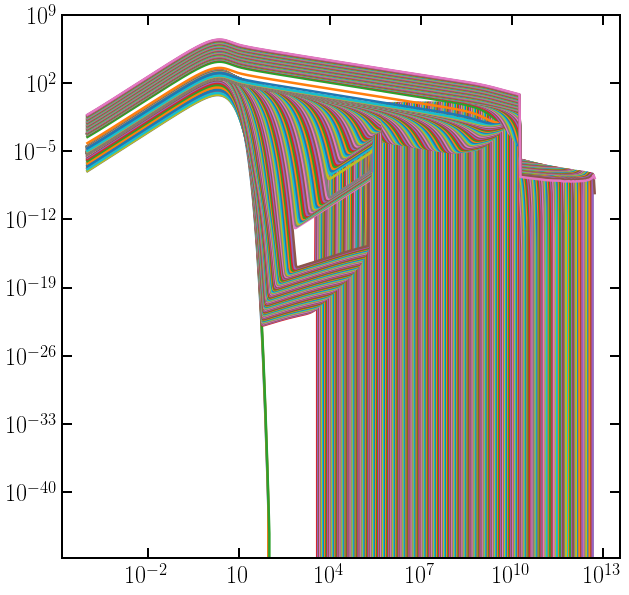

In [17]:
test = tfunclist_photspec_list[-1][-1]
# print(test.rs)

plt.figure()

ax = plt.gca()

# print(test.in_eng[114])
test.plot(ax, step=5)

# test.plot(ax, ind=114, indtype='ind')

# test.plot(ax, ind=(20,25), step=1)
# test.plot(ax, ind=(48, 51), step=1)

ax.loglog()

# plt.axis([3e3, 1e5, 1e-26, 1e3])

In [18]:
ind = 220
# print(test.in_eng)
print(test.in_eng[ind])
print(np.log10(test.in_eng[ind]))
print(np.dot(test[ind].N,test[ind].eng))
print(test[ind].toteng())
print(test.in_eng[ind]/test[ind].toteng())

1509174872.8841581
9.178739565771867
1507745006.8049028
1507745006.8049028
1.0009483474147167


[0.0001, 5000000000000.0, 1e-42, 300.0]

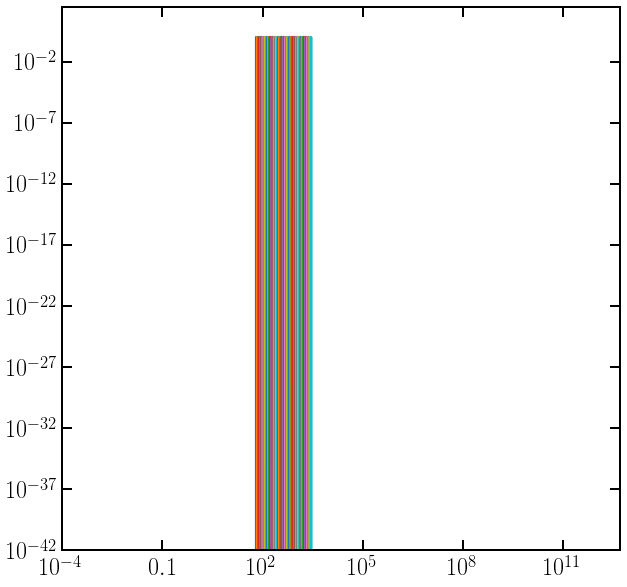

In [19]:
test = tfunclist_lowengphotspec_list[-1][-1]

plt.figure()

ax = plt.gca()

test.plot(ax, step=5)

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 5e12, 1e-42, 3e2])

[0.1, 4000.0, 1e-12, 100.0]

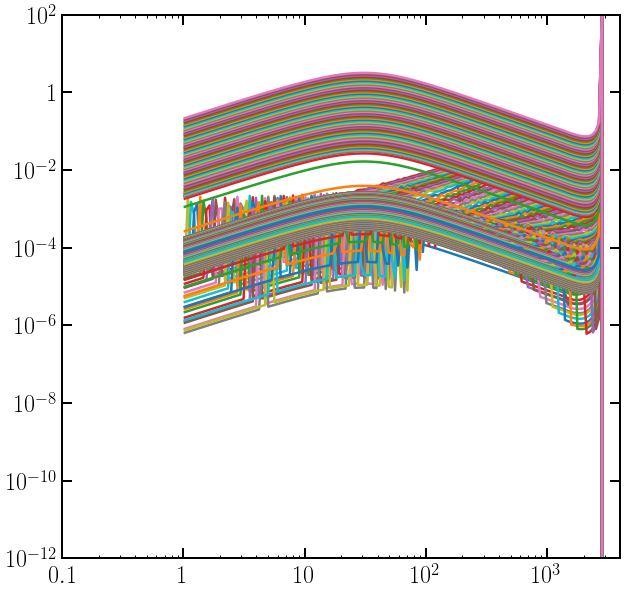

In [20]:
test = tfunclist_lowengelecspec_list[-1][-1]

plt.figure()

ax = plt.gca()

test.plot(ax,step=5)

# test.plot(ax, ind=(0, 326), step=1)
# test.plot(ax, ind=np.array([50]))
ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-1, 4e3, 1e-12, 1e2])

In [21]:
tfunclist_lowengelecspec_list[-1][0].in_eng[76]

22699.913242733463

Save the transfer functions.

In [22]:
# for complete_coarse

# pickle.dump(tfunclist_photspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/tfunclist_photspec_60eV_injE_complete_rs_30_xe_2pts.raw", "wb")
#            )

# pickle.dump(tfunclist_lowengphotspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/tfunclist_lowengphotspec_60eV_injE_complete_rs_30_xe_2pts.raw", "wb")
#            )

# pickle.dump(tfunclist_lowengelecspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/tfunclist_lowengelecspec_60eV_injE_complete_rs_30_xe_2pts.raw", "wb")
#            )

# pickle.dump(
#     new_cmbloss_raw, 
#     open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/CMB_engloss_60eV_injE_complete_rs_30_xe_2pts.raw", "wb")       
#            )

# pickle.dump(
#     new_highdeposited_raw, 
#     open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/highdeposited_60eV_injE_complete_rs_30_xe_2pts.raw", "wb")       
#            )

pickle.dump(tfunclist_photspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/tfunclist_photspec_60eV_complete.raw", "wb")
           )

pickle.dump(tfunclist_lowengphotspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/tfunclist_lowengphotspec_60eV_complete.raw", "wb")
           )

pickle.dump(tfunclist_lowengelecspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/tfunclist_lowengelecspec_60eV_complete.raw", "wb")
           )

pickle.dump(
    new_cmbloss_raw, 
    open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/CMB_engloss_60eV_complete.raw", "wb")       
           )

pickle.dump(
    new_highdeposited_raw, 
    open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/highdeposited_60eV_complete.raw", "wb")       
           )

########################################################
########################################################

# for z=31 test one xe.

# pickle.dump(tfunclist_photspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_list_new_fixed_binning.raw", "wb")
#            )

# pickle.dump(tfunclist_lowengphotspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_list_new_fixed_binning.raw", "wb")
#            )

# pickle.dump(tfunclist_lowengelecspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_list_new_fixed_binning.raw", "wb")
#            )

# pickle.dump(
#     new_cmbloss_raw, 
#     open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_list_new_fixed_binning.raw", "wb")       
#            )

163.15303038335907
2.212595144728543


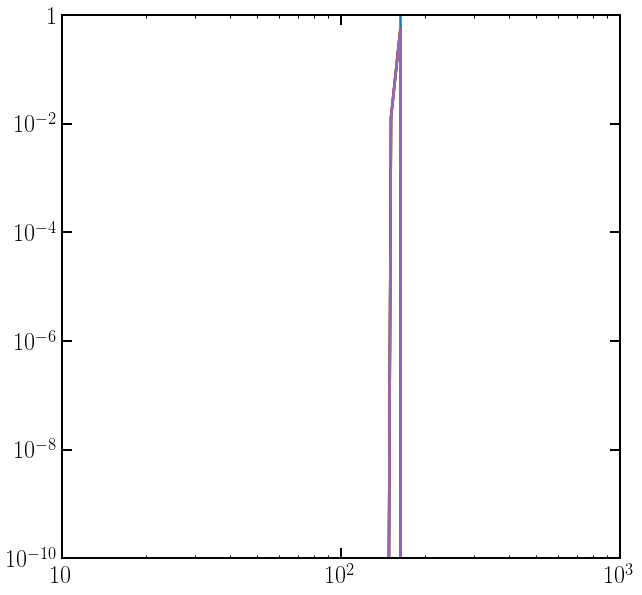

In [23]:
test = tfunclist_photspec_list[-9][0]
print(test.in_eng[12])
print(np.log10(test.in_eng[12]))
# print(test.rs)

plt.figure()
ax = plt.gca()

ax.loglog()

plt.axis([1e1, 1e3, 1e-10, 1])
plt.axvline(x=163.153)

for i in np.arange(5):
    tfunclist_photspec_list[i][0].plot(ax, ind=12, indtype='ind')

In [32]:
new_highdeposited_raw.shape

(11, 327, 51, 4)